In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
SAVE_PATH = "" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)  
#dataset_root = "D:/PhD_FUUAST/mail farina/quanvolution_PC/Dataset_1"
dataset_root = ""
n_layers = 1   # Number of random layers

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


In [ ]:
def load_custom_dataset(root_folder, image_size=(100, 100)):
  class_names = sorted(os.listdir(dataset_root))
  class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
  class_map
  print(class_names)
  for class_name in class_names:
        class_folder = os.path.join(dataset_root, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, image_size)
                    images.append(image)
                    labels.append(class_map[class_name])
                except Exception as e:
                    print(f"Error loading image: {image_path}, Error: {e}")

  return np.array(images), np.array(labels)


images = []
labels = []

In [ ]:
#dataset_root = "/content/gdrive/MyDrive/Dataset_1"
images, labels = load_custom_dataset(dataset_root)
print(f"Loaded {len(images)} images and {len(set(labels))} classes.")
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
n_train = X_train.shape[0]    # Size of the train dataset
n_test = X_test.shape[0]     # Size of the test dataset
train_images=X_train
test_images  =X_test
train_images = train_images / 255
test_images = test_images / 255

In [ ]:
train_images = np.array(train_images[..., np.newaxis])
test_images = np.array(test_images[..., np.newaxis])

In [ ]:
#Run this
import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

# Define the quantum device with 12 qubits
dev = qml.device("default.qubit", wires=4)

# Number of layers in the random circuit
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4,3))
# Random circuit parameters for each color channel
rand_params_red = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
#rand_params_green = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
#rand_params_blue = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

entangler = qml.CZ
# Quantum circuit function
@qml.qnode(dev)
def circuit(phi):
    """Quantum circuit for processing RGB image channels."""

    # Red channel (Q0-Q3)
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
        qml.Hadamard(wires=j)

    



   
    qml.StronglyEntanglingLayers(rand_params[:, :4], wires=[0, 1, 2, 3],imprimitive=entangler)
    #qml.StronglyEntanglingLayers(rand_params[:, 4:8], wires=[4, 5, 6, 7],imprimitive=entangler)
    #qml.StronglyEntanglingLayers(rand_params[:, 8:], wires=[8, 9, 10, 11],imprimitive=entangler)

   

    # Measurement
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input RGB image with the quantum circuit."""
    out = np.zeros((image.shape[0] // 2, image.shape[1] // 2, 4))

    # Process each channel (RGB) separately
    for channel in range(1):
        # Loop over the coordinates of the top-left pixel of 2x2 squares
        for j in range(0, image.shape[0], 2):
            for k in range(0, image.shape[1], 2):
                # Process a squared 2x2 region of the image with the quantum circuit
                q_results = circuit(
                    [
                        image[j, k, 0] ,
                        image[j, k + 1, 0] ,
                        image[j + 1, k, 0] ,
                        image[j + 1, k + 1, 0] 
                    ]
                )
                # Assign expectation values to the output pixel (j/2, k/2, channel)
                for c in range(4):
                    out[j // 2, k // 2, c] = q_results[c]

    return out

In [ ]:


def plot_circuit():
    """Plots the quantum circuit using PennyLane's draw_mpl function."""
    # Create circuit visualization figure
    circuit_fig = qml.draw_mpl(circuit, expansion_strategy="device")([0,0,0,0])

    # Display the circuit diagram
    plt.axis('off')
    plt.show()

# Plot the quantum circuit
plot_circuit()

In [ ]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# Number of layers
n_layers = 5

# Define the entanglers
entanglers = [qml.CZ, qml.CNOT]  # List of entangling gates

# Device setup
dev = qml.device("default.qubit", wires=4)

def create_circuit(layer_num, entangler):
    """Creates a quantum circuit with specified layers and entangler."""
    # Random circuit parameters
    rand_params = np.random.uniform(high=2 * np.pi, size=(layer_num, 4, 3))

    @qml.qnode(dev)
    def circuit(phi):
        for j in range(4):
            qml.RY(np.pi * phi[j], wires=j)
            qml.Hadamard(wires=j)
        qml.StronglyEntanglingLayers(rand_params, wires=list(range(4)), imprimitive=entangler)
        return [qml.expval(qml.PauliZ(j)) for j in range(4)]
    
    return circuit

def plot_and_save_circuit(layer_num, entangler, save_path):
    """Plots and saves the quantum circuit."""
    circuit = create_circuit(layer_num, entangler)
    
    # Plot the quantum circuit
    circuit_fig = qml.draw_mpl(circuit, expansion_strategy="device")([0, 0, 0, 0])
    
    # Save the figure to a file
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Plot and save circuits for each layer and entangler type
save_directory = "D:/PhD_FUUAST/paper2/layers circuit/"
for layer_num in range(1, n_layers + 1):
    for entangler in entanglers:
        entangler_name = "CZ" if entangler == qml.CZ else "CNOT"
        save_path = f"{save_directory}Layer_{layer_num}_{entangler_name}.png"
        plot_and_save_circuit(layer_num, entangler, save_path)
        print(f"Saved Layer {layer_num} with {entangler_name} to {save_path}")


In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "2x2_q_train_images", q_train_images)
    np.save(SAVE_PATH + "2x2_q_test_image", q_test_images)

In [ ]:
np.save(SAVE_PATH + "2x2_q_train_images_0.npy", q_train_images)
np.save(SAVE_PATH + "2x2_q_test_images_0.npy", q_test_images)

print(q_test_images.shape)

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(20,20))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:

# For CNOT gate
train_images_L1_CNOT = np.load(SAVE_PATH + "2x2_q_train_images_0.npy")
test_images_L1_CNOT = np.load(SAVE_PATH + "2x2_q_test_images_0.npy")



In [ ]:
import matplotlib.pyplot as plt

# Number of samples and channels to display
n_samples = 1  # Only 1 sample for comparison
n_channels = 4  # Assuming 4 channels

# List of datasets for all layers (L1 to L5 for CNOT and CZ)
datasets = [
    (train_images_L1_CNOT, "L1 CNOT")
]

# Create a figure for comparison across all layers and operations
fig, axes = plt.subplots(len(datasets), n_channels + 1, figsize=(15, 40))
fig.suptitle("Comparison of Layers Across CNOT and CZ", fontsize=16)

# Iterate over datasets and plot
for i, (images, label) in enumerate(datasets):
    # Input image
    axes[i, 0].set_title(f"{label} Input", fontsize=14)
    axes[i, 0].imshow(images[0, :, :, 0], cmap="gray")
    axes[i, 0].axis('off')  # Hide axes ticks and labels

    # Output channels
    for c in range(n_channels):
        ax = axes[i, c + 1]
        ax.set_title(f"Output [ch. {c}]", fontsize=12)
        ax.imshow(images[0, :, :, c], cmap="gray")
        ax.axis('off')  # Hide axes ticks and labels

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def create_cnn_model(input_shape, num_classes):
    """Creates and returns a CNN model with backpropagation."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def plot_confusion_matrix(cm, categories, title):
    """Plots confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def compute_and_plot_confusion_matrix(model, test_images, test_labels, categories, model_name):
    """Computes and plots the confusion matrix."""
    # Generate predictions
    y_scores = model.predict(test_images)
    predicted_labels = np.argmax(y_scores, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels, labels=np.arange(len(categories)))

    # Plot confusion matrix
    plot_confusion_matrix(cm, categories, f'Confusion Matrix for {model_name}')

def plot_training_validation_accuracy(histories):
    plt.figure(figsize=(15, 10))
    
    # Plot training accuracy
    plt.subplot(2, 1, 1)
    for key, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{key} Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(2, 1, 2)
    for key, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{key} Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_loss(histories):
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 1, 1)
    for key, history in histories.items():
        plt.plot(history.history['loss'], label=f'{key} Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(2, 1, 2)
    for key, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'{key} Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(images, true_labels, predictions, title):
    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predictions[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


datasets = {
    'L1_CNOT': {
        'train': np.load(SAVE_PATH + "2x2_q_train_images_0.npy"),
        'test': np.load(SAVE_PATH + "2x2_q_test_images_0.npy"),
    'L1_CZ': {
        'train': np.load(SAVE_PATH + "2x2_q_train_images_0.npy"),
        'test': np.load(SAVE_PATH + "2x2_q_test_images_0.npy"),
    }
  
}

# Define batch size and number of epochs
batch_size = 32
n_epochs = 40

# Define labels
train_labels = y_train
test_labels = y_test

# Create and train CNN models for different datasets
histories = {}
predictions = {}
test_accuracies = {}
for key, data in datasets.items():
    print(f"Model: {key}")
    
    # Create model
    model = create_cnn_model(input_shape=(50, 50, 4), num_classes=3)
    
    # Print model summary
    print(f"\nSummary for {key} Model:")
    model.summary()
    
    # Train the model
    histories[key] = model.fit(
        data['train'], train_labels,  # Assuming train_labels is the correct label for all
        validation_data=(data['test'], test_labels),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(data['test'], test_labels, verbose=0)
    test_accuracies[key] = test_acc * 100  # Convert to percentage
    # Compute and plot confusion matrix
    compute_and_plot_confusion_matrix(model, test_images, test_labels, categories, key)
    # Generate predictions on the test set
    test_preds = model.predict(data['test'])
    predictions[key] = np.argmax(test_preds, axis=1)
# Plot training and validation accuracy separately
plot_training_validation_accuracy(histories)


# Plot loss separately
plot_loss(histories)

# Print test accuracy for each model
for key, accuracy in test_accuracies.items():
    print(f"Model: {key} - Test Accuracy: {accuracy:.2f}%")


In [ ]:
q_train_images[1, :, :, 1].shape

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
train_labels = y_train
test_labels = y_test
q_model_L1 = MyModel()


# Train models
q_history_L1 = q_model_L1.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=128,
    epochs=300,
    verbose=2,
)



In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    y_train,
    validation_data=(test_images, y_test),
    batch_size=128,
    epochs=300,
    verbose=2,
)

Epoch 124/300
469/469 - 1s - loss: 0.0342 - accuracy: 0.9935 - val_loss: 0.2376 - val_accuracy: 0.9378
Epoch 125/300
469/469 - 1s - loss: 0.0342 - accuracy: 0.9937 - val_loss: 0.2382 - val_accuracy: 0.9380
Epoch 126/300
469/469 - 1s - loss: 0.0341 - accuracy: 0.9936 - val_loss: 0.2382 - val_accuracy: 0.9376
Epoch 127/300
469/469 - 1s - loss: 0.0341 - accuracy: 0.9934 - val_loss: 0.2379 - val_accuracy: 0.9374
Epoch 128/300
469/469 - 1s - loss: 0.0340 - accuracy: 0.9937 - val_loss: 0.2393 - val_accuracy: 0.9368
Epoch 129/300
469/469 - 1s - loss: 0.0339 - accuracy: 0.9936 - val_loss: 0.2384 - val_accuracy: 0.9375
Epoch 130/300
469/469 - 1s - loss: 0.0339 - accuracy: 0.9937 - val_loss: 0.2390 - val_accuracy: 0.9370
Epoch 131/300
469/469 - 1s - loss: 0.0338 - accuracy: 0.9936 - val_loss: 0.2404 - val_accuracy: 0.9370
Epoch 132/300
469/469 - 1s - loss: 0.0338 - accuracy: 0.9938 - val_loss: 0.2393 - val_accuracy: 0.9374
Epoch 133/300
469/469 - 1s - loss: 0.0337 - accuracy: 0.9936 - val_loss: 

Epoch 204/300
469/469 - 1s - loss: 0.0302 - accuracy: 0.9948 - val_loss: 0.2523 - val_accuracy: 0.9362
Epoch 205/300
469/469 - 1s - loss: 0.0302 - accuracy: 0.9949 - val_loss: 0.2514 - val_accuracy: 0.9371
Epoch 206/300
469/469 - 1s - loss: 0.0301 - accuracy: 0.9950 - val_loss: 0.2522 - val_accuracy: 0.9362
Epoch 207/300
469/469 - 1s - loss: 0.0300 - accuracy: 0.9949 - val_loss: 0.2522 - val_accuracy: 0.9376
Epoch 208/300
469/469 - 1s - loss: 0.0300 - accuracy: 0.9948 - val_loss: 0.2530 - val_accuracy: 0.9367
Epoch 209/300
469/469 - 1s - loss: 0.0299 - accuracy: 0.9949 - val_loss: 0.2531 - val_accuracy: 0.9360
Epoch 210/300
469/469 - 1s - loss: 0.0299 - accuracy: 0.9949 - val_loss: 0.2533 - val_accuracy: 0.9359
Epoch 211/300
469/469 - 1s - loss: 0.0299 - accuracy: 0.9949 - val_loss: 0.2542 - val_accuracy: 0.9361
Epoch 212/300
469/469 - 1s - loss: 0.0298 - accuracy: 0.9949 - val_loss: 0.2527 - val_accuracy: 0.9363
Epoch 213/300
469/469 - 1s - loss: 0.0298 - accuracy: 0.9950 - val_loss: 

Epoch 284/300
469/469 - 1s - loss: 0.0268 - accuracy: 0.9959 - val_loss: 0.2668 - val_accuracy: 0.9357
Epoch 285/300
469/469 - 1s - loss: 0.0268 - accuracy: 0.9959 - val_loss: 0.2662 - val_accuracy: 0.9354
Epoch 286/300
469/469 - 1s - loss: 0.0268 - accuracy: 0.9959 - val_loss: 0.2678 - val_accuracy: 0.9353
Epoch 287/300
469/469 - 1s - loss: 0.0267 - accuracy: 0.9959 - val_loss: 0.2666 - val_accuracy: 0.9351
Epoch 288/300
469/469 - 1s - loss: 0.0267 - accuracy: 0.9960 - val_loss: 0.2676 - val_accuracy: 0.9345
Epoch 289/300
469/469 - 1s - loss: 0.0266 - accuracy: 0.9959 - val_loss: 0.2677 - val_accuracy: 0.9348
Epoch 290/300
469/469 - 1s - loss: 0.0266 - accuracy: 0.9958 - val_loss: 0.2680 - val_accuracy: 0.9346
Epoch 291/300
469/469 - 1s - loss: 0.0266 - accuracy: 0.9960 - val_loss: 0.2676 - val_accuracy: 0.9350
Epoch 292/300
469/469 - 1s - loss: 0.0264 - accuracy: 0.9959 - val_loss: 0.2684 - val_accuracy: 0.9349
Epoch 293/300
469/469 - 1s - loss: 0.0265 - accuracy: 0.9959 - val_loss: 

Epoch 65/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 66/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 67/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 68/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 69/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 70/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 71/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 72/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 73/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - val_accuracy: 0.9354
Epoch 74/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9963 - val_loss: 0.2689 - v

Epoch 145/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 146/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 147/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 148/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 149/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 150/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 151/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9354
Epoch 152/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9353
Epoch 153/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2690 - val_accuracy: 0.9353
Epoch 154/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 

Epoch 225/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 226/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 227/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 228/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 229/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 230/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 231/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2691 - val_accuracy: 0.9353
Epoch 232/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2692 - val_accuracy: 0.9353
Epoch 233/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2692 - val_accuracy: 0.9353
Epoch 234/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 

Epoch 5/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9349
Epoch 6/300
469/469 - 1s - loss: 0.0255 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9351
Epoch 7/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2693 - val_accuracy: 0.9352
Epoch 8/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9348
Epoch 9/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9354
Epoch 10/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9348
Epoch 11/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2695 - val_accuracy: 0.9353
Epoch 12/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2698 - val_accuracy: 0.9350
Epoch 13/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.2696 - val_accuracy: 0.9357
Epoch 14/300
469/469 - 1s - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.2695 - val_ac

Epoch 86/300
469/469 - 1s - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.2716 - val_accuracy: 0.9347
Epoch 87/300
469/469 - 1s - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.2714 - val_accuracy: 0.9347
Epoch 88/300
469/469 - 1s - loss: 0.0250 - accuracy: 0.9968 - val_loss: 0.2715 - val_accuracy: 0.9345
Epoch 89/300
469/469 - 1s - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.2714 - val_accuracy: 0.9346
Epoch 90/300
469/469 - 1s - loss: 0.0250 - accuracy: 0.9968 - val_loss: 0.2716 - val_accuracy: 0.9347
Epoch 91/300
469/469 - 1s - loss: 0.0249 - accuracy: 0.9967 - val_loss: 0.2717 - val_accuracy: 0.9341
Epoch 92/300
469/469 - 1s - loss: 0.0249 - accuracy: 0.9968 - val_loss: 0.2717 - val_accuracy: 0.9345
Epoch 93/300
469/469 - 1s - loss: 0.0249 - accuracy: 0.9967 - val_loss: 0.2715 - val_accuracy: 0.9345
Epoch 94/300
469/469 - 1s - loss: 0.0249 - accuracy: 0.9968 - val_loss: 0.2717 - val_accuracy: 0.9347
Epoch 95/300
469/469 - 1s - loss: 0.0249 - accuracy: 0.9967 - val_loss: 0.2715 - v

Epoch 166/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2731 - val_accuracy: 0.9344
Epoch 167/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9970 - val_loss: 0.2730 - val_accuracy: 0.9346
Epoch 168/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2730 - val_accuracy: 0.9344
Epoch 169/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2732 - val_accuracy: 0.9344
Epoch 170/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2730 - val_accuracy: 0.9340
Epoch 171/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2731 - val_accuracy: 0.9339
Epoch 172/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2729 - val_accuracy: 0.9343
Epoch 173/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2729 - val_accuracy: 0.9344
Epoch 174/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.2732 - val_accuracy: 0.9343
Epoch 175/300
469/469 - 1s - loss: 0.0246 - accuracy: 0.9969 - val_loss: 

Epoch 246/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2744 - val_accuracy: 0.9340
Epoch 247/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2743 - val_accuracy: 0.9341
Epoch 248/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9971 - val_loss: 0.2746 - val_accuracy: 0.9347
Epoch 249/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9971 - val_loss: 0.2746 - val_accuracy: 0.9340
Epoch 250/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9971 - val_loss: 0.2746 - val_accuracy: 0.9344
Epoch 251/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2745 - val_accuracy: 0.9343
Epoch 252/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2744 - val_accuracy: 0.9343
Epoch 253/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2746 - val_accuracy: 0.9344
Epoch 254/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.2747 - val_accuracy: 0.9345
Epoch 255/300
469/469 - 1s - loss: 0.0243 - accuracy: 0.9970 - val_loss: 

Epoch 26/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.2765 - val_accuracy: 0.9339
Epoch 27/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.2762 - val_accuracy: 0.9339
Epoch 28/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.2761 - val_accuracy: 0.9346
Epoch 29/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.2765 - val_accuracy: 0.9338
Epoch 30/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9973 - val_loss: 0.2764 - val_accuracy: 0.9342
Epoch 31/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9973 - val_loss: 0.2766 - val_accuracy: 0.9339
Epoch 32/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9973 - val_loss: 0.2769 - val_accuracy: 0.9341
Epoch 33/300
469/469 - 1s - loss: 0.0238 - accuracy: 0.9972 - val_loss: 0.2772 - val_accuracy: 0.9340
Epoch 34/300
469/469 - 1s - loss: 0.0237 - accuracy: 0.9972 - val_loss: 0.2765 - val_accuracy: 0.9337
Epoch 35/300
469/469 - 1s - loss: 0.0237 - accuracy: 0.9973 - val_loss: 0.2770 - v

Epoch 107/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9974 - val_loss: 0.2795 - val_accuracy: 0.9339
Epoch 108/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9975 - val_loss: 0.2802 - val_accuracy: 0.9343
Epoch 109/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9975 - val_loss: 0.2797 - val_accuracy: 0.9340
Epoch 110/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9976 - val_loss: 0.2799 - val_accuracy: 0.9345
Epoch 111/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9974 - val_loss: 0.2798 - val_accuracy: 0.9338
Epoch 112/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9976 - val_loss: 0.2801 - val_accuracy: 0.9342
Epoch 113/300
469/469 - 1s - loss: 0.0229 - accuracy: 0.9975 - val_loss: 0.2802 - val_accuracy: 0.9341
Epoch 114/300
469/469 - 1s - loss: 0.0228 - accuracy: 0.9976 - val_loss: 0.2803 - val_accuracy: 0.9336
Epoch 115/300
469/469 - 1s - loss: 0.0228 - accuracy: 0.9975 - val_loss: 0.2804 - val_accuracy: 0.9347
Epoch 116/300
469/469 - 1s - loss: 0.0228 - accuracy: 0.9975 - val_loss: 

Epoch 187/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9978 - val_loss: 0.2834 - val_accuracy: 0.9343
Epoch 188/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9978 - val_loss: 0.2836 - val_accuracy: 0.9342
Epoch 189/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9978 - val_loss: 0.2835 - val_accuracy: 0.9338
Epoch 190/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9979 - val_loss: 0.2835 - val_accuracy: 0.9343
Epoch 191/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9977 - val_loss: 0.2835 - val_accuracy: 0.9340
Epoch 192/300
469/469 - 1s - loss: 0.0220 - accuracy: 0.9979 - val_loss: 0.2839 - val_accuracy: 0.9339
Epoch 193/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9977 - val_loss: 0.2837 - val_accuracy: 0.9340
Epoch 194/300
469/469 - 1s - loss: 0.0221 - accuracy: 0.9978 - val_loss: 0.2838 - val_accuracy: 0.9341
Epoch 195/300
469/469 - 1s - loss: 0.0220 - accuracy: 0.9977 - val_loss: 0.2838 - val_accuracy: 0.9342
Epoch 196/300
469/469 - 1s - loss: 0.0220 - accuracy: 0.9979 - val_loss: 

Epoch 267/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2870 - val_accuracy: 0.9339
Epoch 268/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9980 - val_loss: 0.2867 - val_accuracy: 0.9338
Epoch 269/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2872 - val_accuracy: 0.9340
Epoch 270/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2873 - val_accuracy: 0.9340
Epoch 271/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2874 - val_accuracy: 0.9342
Epoch 272/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2876 - val_accuracy: 0.9343
Epoch 273/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2872 - val_accuracy: 0.9339
Epoch 274/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2874 - val_accuracy: 0.9336
Epoch 275/300
469/469 - 1s - loss: 0.0213 - accuracy: 0.9981 - val_loss: 0.2872 - val_accuracy: 0.9337
Epoch 276/300
469/469 - 1s - loss: 0.0212 - accuracy: 0.9981 - val_loss: 

469/469 - 1s - loss: 0.0183 - accuracy: 0.9986 - val_loss: 0.3104 - val_accuracy: 0.9329
Epoch 48/300
469/469 - 1s - loss: 0.0182 - accuracy: 0.9986 - val_loss: 0.3096 - val_accuracy: 0.9332
Epoch 49/300
469/469 - 1s - loss: 0.0181 - accuracy: 0.9987 - val_loss: 0.3111 - val_accuracy: 0.9326
Epoch 50/300
469/469 - 1s - loss: 0.0181 - accuracy: 0.9987 - val_loss: 0.3115 - val_accuracy: 0.9329
Epoch 51/300
469/469 - 1s - loss: 0.0180 - accuracy: 0.9988 - val_loss: 0.3116 - val_accuracy: 0.9319
Epoch 52/300
469/469 - 1s - loss: 0.0179 - accuracy: 0.9988 - val_loss: 0.3121 - val_accuracy: 0.9327
Epoch 53/300
469/469 - 1s - loss: 0.0178 - accuracy: 0.9989 - val_loss: 0.3134 - val_accuracy: 0.9325
Epoch 54/300
469/469 - 1s - loss: 0.0178 - accuracy: 0.9988 - val_loss: 0.3128 - val_accuracy: 0.9320
Epoch 55/300
469/469 - 1s - loss: 0.0177 - accuracy: 0.9987 - val_loss: 0.3135 - val_accuracy: 0.9331
Epoch 56/300
469/469 - 1s - loss: 0.0176 - accuracy: 0.9988 - val_loss: 0.3137 - val_accuracy: 

Epoch 128/300
469/469 - 1s - loss: 0.0134 - accuracy: 0.9995 - val_loss: 0.3470 - val_accuracy: 0.9316
Epoch 129/300
469/469 - 1s - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.3462 - val_accuracy: 0.9314
Epoch 130/300
469/469 - 1s - loss: 0.0133 - accuracy: 0.9996 - val_loss: 0.3475 - val_accuracy: 0.9312
Epoch 131/300
469/469 - 1s - loss: 0.0132 - accuracy: 0.9996 - val_loss: 0.3493 - val_accuracy: 0.9313
Epoch 132/300
469/469 - 1s - loss: 0.0132 - accuracy: 0.9996 - val_loss: 0.3484 - val_accuracy: 0.9314
Epoch 133/300
469/469 - 1s - loss: 0.0132 - accuracy: 0.9996 - val_loss: 0.3493 - val_accuracy: 0.9316
Epoch 134/300
469/469 - 1s - loss: 0.0131 - accuracy: 0.9995 - val_loss: 0.3497 - val_accuracy: 0.9312
Epoch 135/300
469/469 - 1s - loss: 0.0130 - accuracy: 0.9996 - val_loss: 0.3497 - val_accuracy: 0.9316
Epoch 136/300
469/469 - 1s - loss: 0.0130 - accuracy: 0.9996 - val_loss: 0.3506 - val_accuracy: 0.9314
Epoch 137/300
469/469 - 1s - loss: 0.0130 - accuracy: 0.9996 - val_loss: 

Epoch 208/300
469/469 - 1s - loss: 0.0100 - accuracy: 0.9999 - val_loss: 0.3834 - val_accuracy: 0.9305
Epoch 209/300
469/469 - 1s - loss: 0.0100 - accuracy: 0.9998 - val_loss: 0.3833 - val_accuracy: 0.9305
Epoch 210/300
469/469 - 1s - loss: 0.0099 - accuracy: 0.9999 - val_loss: 0.3841 - val_accuracy: 0.9303
Epoch 211/300
469/469 - 1s - loss: 0.0099 - accuracy: 0.9999 - val_loss: 0.3850 - val_accuracy: 0.9302
Epoch 212/300
469/469 - 1s - loss: 0.0099 - accuracy: 0.9998 - val_loss: 0.3835 - val_accuracy: 0.9301
Epoch 213/300
469/469 - 1s - loss: 0.0098 - accuracy: 0.9998 - val_loss: 0.3852 - val_accuracy: 0.9309
Epoch 214/300
469/469 - 1s - loss: 0.0098 - accuracy: 0.9998 - val_loss: 0.3861 - val_accuracy: 0.9300
Epoch 215/300
469/469 - 1s - loss: 0.0098 - accuracy: 0.9999 - val_loss: 0.3854 - val_accuracy: 0.9300
Epoch 216/300
469/469 - 1s - loss: 0.0097 - accuracy: 0.9998 - val_loss: 0.3862 - val_accuracy: 0.9307
Epoch 217/300
469/469 - 1s - loss: 0.0097 - accuracy: 0.9998 - val_loss: 

Epoch 288/300
469/469 - 1s - loss: 0.0076 - accuracy: 0.9999 - val_loss: 0.4196 - val_accuracy: 0.9291
Epoch 289/300
469/469 - 1s - loss: 0.0075 - accuracy: 0.9999 - val_loss: 0.4198 - val_accuracy: 0.9291
Epoch 290/300
469/469 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4212 - val_accuracy: 0.9297
Epoch 291/300
469/469 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4207 - val_accuracy: 0.9294
Epoch 292/300
469/469 - 1s - loss: 0.0074 - accuracy: 0.9999 - val_loss: 0.4218 - val_accuracy: 0.9292
Epoch 293/300
469/469 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.9288
Epoch 294/300
469/469 - 1s - loss: 0.0074 - accuracy: 0.9999 - val_loss: 0.4225 - val_accuracy: 0.9291
Epoch 295/300
469/469 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4233 - val_accuracy: 0.9299
Epoch 296/300
469/469 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.4234 - val_accuracy: 0.9297
Epoch 297/300
469/469 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 

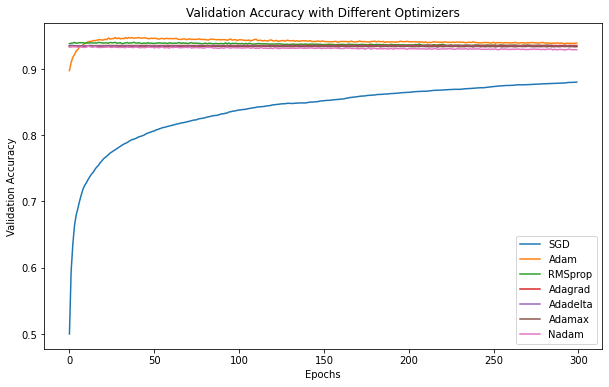

Test Accuracy for SGD: 0.8802000284194946
Test Accuracy for Adam: 0.9391000270843506
Test Accuracy for RMSprop: 0.9348000288009644
Test Accuracy for Adagrad: 0.9354000091552734
Test Accuracy for Adadelta: 0.9340999722480774
Test Accuracy for Adamax: 0.9337000250816345
Test Accuracy for Nadam: 0.929099977016449


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from sklearn.metrics import accuracy_score

# Define a list of optimizers to try
optimizers = [
    SGD(learning_rate=0.01),
    Adam(learning_rate=0.001),
    RMSprop(learning_rate=0.001),
    Adagrad(learning_rate=0.01),
    Adadelta(learning_rate=1.0),
    Adamax(learning_rate=0.001),
    Nadam(learning_rate=0.002),
]

optimizer_names = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']

# Initialize a dictionary to store accuracy for each optimizer
optimizer_accuracy = {}

# Create and compile the model
q1_model = MyModel()
test_acc = []

# Loop through each optimizer
for i, optimizer in enumerate(optimizers):
    # Create a new instance of the model for each optimizer
    q1_model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    # Train the model
    history = q1_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=128,
        epochs=300,
        verbose=2,
    )
    
    # Record the validation accuracy for the current optimizer
    optimizer_accuracy[optimizer_names[i]] = history.history['val_accuracy']
    
    # Evaluate the model on the test set and append the accuracy to the list
    test_scores = q1_model.evaluate(q_test_images, test_labels, verbose=0)
    test_accuracy = test_scores[1]  # Assuming accuracy is the second element in the test_scores list
    test_acc.append(test_accuracy)

# Plot the accuracy for different optimizers
plt.figure(figsize=(10, 6))
for optimizer_name, accuracy in optimizer_accuracy.items():
    plt.plot(range(300), accuracy, label=optimizer_name)

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy with Different Optimizers')
plt.legend()
plt.show()

# Print the test accuracy for each optimizer
for i, optimizer_name in enumerate(optimizer_names):
    print(f'Test Accuracy for {optimizer_name}: {test_acc[i]}')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def create_cnn_model(input_shape, num_classes):
    """Creates and returns a CNN model with backpropagation."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def plot_confusion_matrix(cm, categories, title):
    """Plots confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def compute_and_plot_confusion_matrix(model, test_images, test_labels, categories, model_name):
    """Computes and plots the confusion matrix."""
    # Generate predictions
    y_scores = model.predict(test_images)
    predicted_labels = np.argmax(y_scores, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels, labels=np.arange(len(categories)))

    # Plot confusion matrix
    plot_confusion_matrix(cm, categories, f'Confusion Matrix for {model_name}')

def plot_training_validation_accuracy(histories):
    plt.figure(figsize=(15, 10))
    
    # Plot training accuracy
    plt.subplot(2, 1, 1)
    for key, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{key} Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(2, 1, 2)
    for key, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{key} Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_loss(histories):
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 1, 1)
    for key, history in histories.items():
        plt.plot(history.history['loss'], label=f'{key} Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(2, 1, 2)
    for key, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'{key} Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(images, true_labels, predictions, title):
    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predictions[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


datasets = {
    'L1_CNOT': {
        'train': np.load(SAVE_PATH + "2x2_q_train_images_Apple_L1_CNOT_01082024_100.npy"),
        'test': np.load(SAVE_PATH + "2x2_q_test_images_Apple_L1_CNOT_01082024_100.npy"),
    },
    'L1_CZ': {
        'train': np.load(SAVE_PATH + "2x2_q_train_images_Apple_L1_CZ_01082024_100.npy"),
        'test': np.load(SAVE_PATH + "2x2_q_test_images_Apple_L1_CZ_01082024_100.npy"),
   }
}

# Define batch size and number of epochs
batch_size = 32
n_epochs = 40

# Define labels
train_labels = y_train
test_labels = y_test

# Create and train CNN models for different datasets
histories = {}
predictions = {}
test_accuracies = {}
for key, data in datasets.items():
    print(f"Model: {key}")
    
    # Create model
    model = create_cnn_model(input_shape=(50, 50, 4), num_classes=3)
    
    # Print model summary
    print(f"\nSummary for {key} Model:")
    model.summary()
    
    # Train the model
    histories[key] = model.fit(
        data['train'], train_labels,  # Assuming train_labels is the correct label for all
        validation_data=(data['test'], test_labels),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(data['test'], test_labels, verbose=0)
    test_accuracies[key] = test_acc * 100  # Convert to percentage
    # Compute and plot confusion matrix
    compute_and_plot_confusion_matrix(model, test_images, test_labels, categories, key)
    # Generate predictions on the test set
    test_preds = model.predict(data['test'])
    predictions[key] = np.argmax(test_preds, axis=1)
# Plot training and validation accuracy separately
plot_training_validation_accuracy(histories)


# Plot loss separately
plot_loss(histories)

# Print test accuracy for each model
for key, accuracy in test_accuracies.items():
    print(f"Model: {key} - Test Accuracy: {accuracy:.2f}%")
